In [2]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 58.3 MB/s eta 0:00:00


In [3]:
# Basic Modules
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
# For Identifying Duplicates
import imagehash
# For Visualization and Feature Reduction
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# For Feature Extraction
from scipy.fft import fft2, fftshift
from skimage.feature import hog
from skimage import exposure
# For Feature Selection
from sklearn.feature_selection import f_classif, SelectKBest
# For Cross-Validation
from sklearn.model_selection import train_test_split, StratifiedKFold
# For Classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC # for multi-class
from sklearn.ensemble import RandomForestClassifier
# For Image Transformations
from torchvision import transforms

All Functions

In [4]:
#%% Functions

def find_duplicate_images(dataset_path, categories):
    hash_dict = {}
    duplicates = []
    for category in categories:
        folder_path = os.path.join(dataset_path, category)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.jpg') or file_name.endswith('.png') or file_name.endswith('.jpeg'):
                image_path = os.path.join(folder_path, file_name)
                # Load the image and compute its hash
                image = Image.open(image_path)
                image_hash = imagehash.average_hash(image)
                # Check if the hash is already in the dictionary
                if image_hash in hash_dict:
                    duplicates.append((image_path, hash_dict[image_hash]))  # Store the duplicate image path
                else:
                    hash_dict[image_hash] = image_path  # Store the image path by its hash
    return duplicates

def compute_fft_magnitude(image, low_freq_filter=10, flatten=False, plot_img=False, plot_fft=False):
    # Apply Fourier Transform
    f_transform = fft2(image)
    # Shift zero-frequency component to center
    f_transform_shifted = fftshift(f_transform)
    # Magnitude Spectrum + add small epsilon value to avoid log(0) issue
    epsilon = 1e-10
    magnitude_spectrum = np.log10(np.abs(f_transform_shifted) + epsilon)
    if plot_img == True:
        # Visualize image
        plt.imshow(image)
        plt.title('Original Image')
        plt.show()
    if plot_fft == True:
        # Normalize magnitude to range [0, 1] (else floats can't be imshow plotted)
        magnitude_spectrum_normalized = (magnitude_spectrum - np.min(magnitude_spectrum)) / (np.max(magnitude_spectrum) - np.min(magnitude_spectrum))
        # Visualize magnitude spectrum
        plt.imshow(magnitude_spectrum_normalized, cmap='gray')
        plt.title('Fourier Magnitude Spectrum')
        plt.show()
    if flatten == True:
        # Flatten the magnitude spectrum
        X_fourier = magnitude_spectrum.flatten()
    else:
        X_fourier = magnitude_spectrum
    return X_fourier

# low-pass filter for FFT to reduce feature space
def reduce_fft_features(magnitude_spectrum, crop_size, plot_fft=False, flatten=False):
    # Get the center portion of the magnitude spectrum
    center_x, center_y = magnitude_spectrum.shape[0] // 2, magnitude_spectrum.shape[1] // 2
    half_crop = crop_size // 2
    cropped_magnitude = magnitude_spectrum[center_x - half_crop : center_x + half_crop,
                                           center_y - half_crop : center_y + half_crop]
    if plot_fft == True:
        # Visualize magnitude spectrum
        cropped_magnitude_normalized = (cropped_magnitude - np.min(cropped_magnitude)) / (np.max(cropped_magnitude) - np.min(cropped_magnitude))
        plt.imshow(cropped_magnitude_normalized, cmap='gray')
        plt.title(f"Reduced Feature - FFT - crop size = {crop_size}")
        plt.show()
    if flatten==True:
        cropped_magnitude =  cropped_magnitude.flatten()
    return cropped_magnitude


# Flattening for all images
def flatten_image_set(images):
    flattened_images = []
    for image in images:
        flattened_images.append(image.flatten())
    return np.array(flattened_images)

# Compute Fourier Transform magnitude for all images with low-pass filtering option
def fft_image_set(images, crop_size=None):
    fft_features = []
    for image in images:
        if crop_size == None:
            fft_feature = compute_fft_magnitude(image, flatten=True)
        else:
            fft_feature = compute_fft_magnitude(image)
            fft_feature = reduce_fft_features(fft_feature, crop_size, flatten=True)
        fft_features.append(fft_feature)
    return np.array(fft_features)

# HOG Features Extraction for entire Image Dataset
def apply_hog(images):
    hog_features = []
    hog_images = []
    for image in images:
        # Compute HOG features
        features, hog_image = hog(image, pixels_per_cell=(16, 16),
                                  cells_per_block=(2, 2), visualize=True,
                                  block_norm='L2', channel_axis=2)
        # Normalize HOG image for better visualization
        hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        # Add features and images to corresponding lists
        hog_features.append(features)
        hog_images.append(hog_image)
    return np.array(hog_features), hog_images

# Define the transformations
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25),
    transforms.ToTensor()
])

# Function to perform augmentations
def augment_images(images, num_augmentations_needed):
    augmented_images = []
    for _ in range(num_augmentations_needed):
        image = random.choice(images)  # Randomly pick an existing image
        # Check if the data type is correct
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)  # Scale to 0-255 if necessary
        image = Image.fromarray(image).convert('RGB')
        augmented_image = data_transforms(image)
        # Convert from Tensor to NumPy array
        augmented_image_np = augmented_image.permute(1, 2, 0).numpy()  # Permute to [184, 184, 3]
        augmented_images.append(augmented_image_np)
    return augmented_images

def balanced_augmentation(X, y, N_class=None, visualize=False):
    _, counts = np.unique(y, return_counts=True)
    N_max = max(counts)
    if N_class==None:
        # Upsample to N which belongs to the maximum samples of a class
        num_augmentations_needed = N_max - counts
    elif N_class<max(counts):
        print("N_class must be > ",N_max)
        return 0
    else:
        num_augmentations_needed = [N_class] * len(counts)
    # Add augmented images and labels to corresponding lists
    class_augmented_images = []
    class_augmented_labels = []
    for class_idx, num_aug in enumerate(num_augmentations_needed):
        if num_aug > 0:
            class_images = X[y == class_idx]
            augmented_images = augment_images(class_images, num_aug)
            class_augmented_images.append(augmented_images)
            # Add labels equal to the number of augmentations
            class_augmented_labels.extend([class_idx] * num_aug)
    # Flatten the list of lists into a single list of augmented images
    class_augmented_images = [img for sublist in class_augmented_images for img in sublist]
    if visualize==True:
        num_to_display = 5
        plt.figure(figsize=(15, 5))
        for i in range(num_to_display):
            plt.subplot(1, num_to_display, i + 1)
            plt.imshow(class_augmented_images[np.random.randint(0,len(class_augmented_images))])
            plt.axis('off')
        plt.show()
    return np.array(class_augmented_images), np.array(class_augmented_labels)

def plot_image(index, images, labels, categories):
    # Get the image and label
    image = images[index]
    label = labels[index]
    # Create the plot
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')  # Hide the axes
    plt.title(f"Category: {categories[label]}")
    plt.show()

def plot_duplicate_images(duplicates, image_paths, labels, categories):
    for i, dup in enumerate(duplicates):
        dup1_path, dup2_path = dup
        # Get the indices of the duplicate images in the image_paths list
        dup1_index = image_paths.index(dup1_path)
        dup2_index = image_paths.index(dup2_path)
        # Load the images
        image1 = images[dup1_index]
        image2 = images[dup2_index]
        # Get the labels (categories)
        label1 = labels[dup1_index]
        label2 = labels[dup2_index]
        # Print the image paths
        print("Pair ",i+1,":")
        print(f"Duplicate 1 Path: {dup1_path}")
        print(f"Duplicate 2 Path: {dup2_path}")
        # Create a subplot with 2 images
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
        # Display first image
        axes[0].imshow(image1)
        axes[0].axis('off')  # Hide the axes
        axes[0].set_title(f"Category: {categories[label1]}")
        # Display second image
        axes[1].imshow(image2)
        axes[1].axis('off')  # Hide the axes
        axes[1].set_title(f"Category: {categories[label2]}")
        # Display the plot
        plt.show()

# Function to plot 2D features
def plot_2d_projection(features_2d, labels, categories, method_name):
    plt.figure()
    for i, category in enumerate(categories):
        indices = np.where(labels == i)
        plt.scatter(features_2d[indices, 0], features_2d[indices, 1], label=category, alpha=0.65)
    plt.legend(loc='best')
    plt.title(f"2D Projection with {method_name}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

# Function to plot 3D features
def plot_3d_projection(features_3d, labels, categories, method_name):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i, category in enumerate(categories):
        indices = np.where(labels == i)  # Changed from labels_cleaned to labels
        ax.scatter(features_3d[indices, 0], features_3d[indices, 1], features_3d[indices, 2], label=category, alpha=0.65)
    ax.legend(loc='best')
    ax.set_title(f"3D Projection with {method_name}")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
    plt.show()

def plot_feature_importance(X, y, num_top=10, num_bottom=10, xticks_fontsize=7):
    # Compute F and p values with f_classif (ANOVA)
    f_values, p_values = f_classif(X, y)
    # Sort based on p_values (ascending order - most important indices in front)
    sorted_indices = np.argsort(p_values)
    # Select top 10 most important and bottom 10 least important indices
    top_features_indices = sorted_indices[:num_top]
    least_significant_features_indices = sorted_indices[-num_bottom:]
    # Merge Top and Bottom indices
    selected_indices = np.concatenate([top_features_indices, least_significant_features_indices])
    # BarPlot - F-value
    plt.figure()
    plt.bar(range(len(selected_indices)), f_values[selected_indices], color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('F-Value')
    plt.title('Top and Less Significant Features Ranked by Importance (ANOVA)')
    plt.xticks(ticks=range(len(selected_indices)), labels=selected_indices, fontsize=xticks_fontsize, rotation=90)
    plt.tight_layout()
    plt.show()

# Function to plot KNN results for different features when Tuning
def plot_knn_results(average_results_knn_anova, feature_grid, k_values, legend_loc,
                     legend_fontsize, title):
    plt.figure(figsize=(10, 6))
    for k in k_values:
        # Prepare lists to store train and validation accuracies
        train_accuracies = []
        val_accuracies = []
        # Iterate through the number of features selected in ANOVA
        for num_features in feature_grid:
            train_accuracies.append(average_results_knn_anova[(k, num_features)]['train'])
            val_accuracies.append(average_results_knn_anova[(k, num_features)]['validation'])
        # Plot training accuracy with '--' linestyle
        plt.plot(feature_grid, train_accuracies, linestyle='--', label=f'KNN (k={k}) - Train')
        # Plot validation accuracy with default linestyle
        plt.plot(feature_grid, val_accuracies, label=f'KNN (k={k}) - Validation')
    plt.xlabel('Number of Features Selected')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend(loc=legend_loc, fontsize=legend_fontsize)
    plt.grid(True)
    plt.show()

# Function to plot SVM results for different features when Tuning
def plot_svm_results(average_results_svm_anova, feature_grid, title):
    plt.figure(figsize=(10, 6))
    train_accuracies = []
    val_accuracies = []
    # Iterate through the number of features selected in ANOVA
    for num_features in feature_grid:
        train_accuracies.append(average_results_svm_anova[(0, num_features)]['train'])
        val_accuracies.append(average_results_svm_anova[(0, num_features)]['validation'])
    # Plot training accuracy with '--' linestyle
    plt.plot(feature_grid, train_accuracies, linestyle='--', label='SVM - Train')
    # Plot validation accuracy with default linestyle
    plt.plot(feature_grid, val_accuracies, label='SVM - Validation')
    plt.xlabel('Number of Features Selected')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Function to plot Random Forest results for different numbers of estimators
def plot_rf_results(average_results_rf, rf_estimator_grid, title):
    plt.figure(figsize=(10, 6))
    train_accuracies = []
    val_accuracies = []
    # Iterate through the number of estimators in Random Forest
    for n_estimators in rf_estimator_grid:
        train_accuracies.append(average_results_rf[n_estimators]['train'])
        val_accuracies.append(average_results_rf[n_estimators]['validation'])
    # Plot training accuracy with '--' linestyle
    plt.plot(rf_estimator_grid, train_accuracies, linestyle='--', label='Random Forest - Train')
    # Plot validation accuracy with default linestyle
    plt.plot(rf_estimator_grid, val_accuracies, label='Random Forest - Validation')
    plt.xlabel('Number of Estimators (Trees)')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

def plot_knn_lda_results(average_results_knn_lda, k_values, title):
    plt.figure(figsize=(10, 6))
    train_accuracies = []
    val_accuracies = []
    # Iterate through different k values
    for k in k_values:
        train_accuracies.append(average_results_knn_lda[k]['train'])
        val_accuracies.append(average_results_knn_lda[k]['validation'])
    # Plot training accuracy with '--' linestyle
    plt.plot(k_values, train_accuracies, linestyle='--', label='KNN (LDA) - Train')
    # Plot validation accuracy with default linestyle
    plt.plot(k_values, val_accuracies, label='KNN (LDA) - Validation')
    plt.xlabel('k Values (Number of Neighbors)')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_per_class_accuracy(results_per_class):
    # Extract unique class labels from the results
    unique_classes = set(class_label for fold_results in results_per_class.values()
                                for class_label in fold_results)
    # Number of folds
    n_folds = len(results_per_class)
    # Create plot
    plt.figure(figsize=(10, 6))
    # Generate color map for different classes
    colors = plt.cm.get_cmap('tab10', len(unique_classes))
    for i, class_label in enumerate(unique_classes):
        class_accuracies = [results_per_class[fold].get(class_label, [0])[0] for fold in range(n_folds)]
        # Plot class accuracy across folds
        plt.plot(range(1, n_folds + 1), class_accuracies,
                 label=f'Class {class_label}', marker='o', color=colors(i))
    plt.title('Per-Class Accuracy across Folds')
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, n_folds + 1))  # Set x-ticks as fold numbers
    plt.ylim(0, 1.05)  # Accuracy range from 0 to 1
    plt.grid(True)
    plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# for tuning process involving fft transform and crop sizes

# General function to plot results for different models
def plot_fft_classification_results(average_results, param_grid, model_type, param_name, title, k_values=None):
    plt.figure(figsize=(10, 6))
    if model_type == 'KNN':
        for k in k_values:
            # Prepare lists to store train and validation accuracies
            train_accuracies = []
            val_accuracies = []
            # Iterate through crop sizes and collect results
            for crop_size in param_grid:
                train_accuracies.append(average_results[(k, crop_size)]['train'])
                val_accuracies.append(average_results[(k, crop_size)]['validation'])
            # Plot training accuracy with '--' linestyle
            plt.plot(param_grid, train_accuracies, linestyle='--', label=f'KNN (k={k}) - Train')
            # Plot validation accuracy with default linestyle
            plt.plot(param_grid, val_accuracies, label=f'KNN (k={k}) - Validation')
    elif model_type in ['SVM6', 'SVM8', 'SVM10', 'SVM14']:
        train_accuracies = []
        val_accuracies = []
        # Iterate through crop sizes and collect results
        for crop_size in param_grid:
            train_accuracies.append(average_results[crop_size]['train'])
            val_accuracies.append(average_results[crop_size]['validation'])
        # Plot training accuracy with '--' linestyle
        plt.plot(param_grid, train_accuracies, linestyle='--', label=f'{model_type} - Train')
        # Plot validation accuracy with default linestyle
        plt.plot(param_grid, val_accuracies, label=f'{model_type} - Validation')
    elif model_type == 'RF':
        train_accuracies = []
        val_accuracies = []
        # Iterate through the number of estimators
        for n_estimators in param_grid:
            train_accuracies.append(average_results[n_estimators]['train'])
            val_accuracies.append(average_results[n_estimators]['validation'])
        # Plot training accuracy with '--' linestyle
        plt.plot(param_grid, train_accuracies, linestyle='--', label='Random Forest - Train')
        # Plot validation accuracy with default linestyle
        plt.plot(param_grid, val_accuracies, label='Random Forest - Validation')
    plt.xlabel(f'{param_name}')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


In [5]:
#%% Load dataset

# Define path to dataset folder
dataset_path = r'/content/drive/MyDrive/BigCats'
# Define categories/subfolders in dataset
categories = ['Cheetah', 'Jaguar', 'Leopard', 'Lion', 'Tiger']
# Initialize empty lists to store images, labels, and paths
images = []
labels = []
image_paths = []  # List to store the file paths of images
# Set fixed image size
N = 128
img_size = (N, N)
# Iterate over each category to load images
for label, category in enumerate(categories):
    folder_path = os.path.join(dataset_path, category)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.jpeg') or file_name.endswith('.png') or file_name.endswith('.jpg'):
            image_path = os.path.join(folder_path, file_name)
            image = Image.open(image_path)
            image = image.resize(img_size)
            images.append(np.array(image))
            labels.append(label)
            image_paths.append(image_path)  # Append the image path
# Convert lists to numpy arrays for further processing
images = np.array(images)
labels = np.array(labels)

Find and Remove Duplicates

Pair  1 :
Duplicate 1 Path: /content/drive/MyDrive/BigCats/Cheetah/cheetah-223734__340.jpg
Duplicate 2 Path: /content/drive/MyDrive/BigCats/Cheetah/cheetah-predator-wild-animal-speed-59952.jpeg


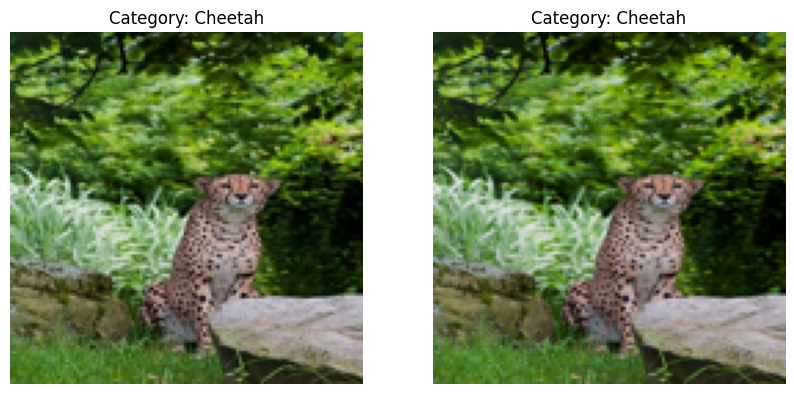

Pair  2 :
Duplicate 1 Path: /content/drive/MyDrive/BigCats/Jaguar/photo-1477949775154-d739b82400b3 (1).jpg
Duplicate 2 Path: /content/drive/MyDrive/BigCats/Jaguar/photo-1477949775154-d739b82400b3.jpg


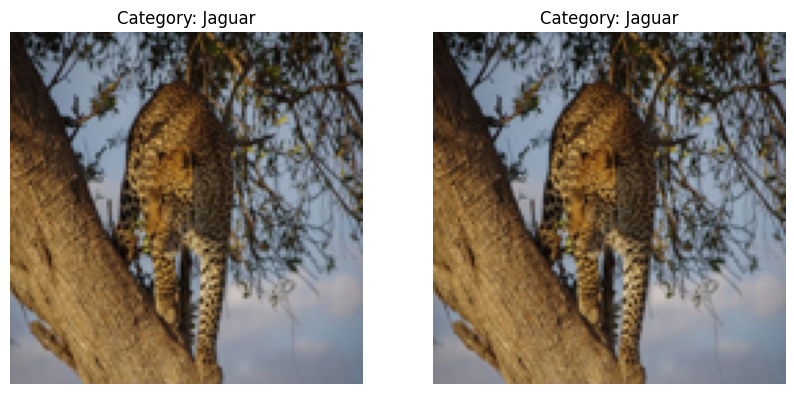

Pair  3 :
Duplicate 1 Path: /content/drive/MyDrive/BigCats/Jaguar/pexels-photo-4468189 (1).jpeg
Duplicate 2 Path: /content/drive/MyDrive/BigCats/Jaguar/pexels-photo-4468189.jpeg


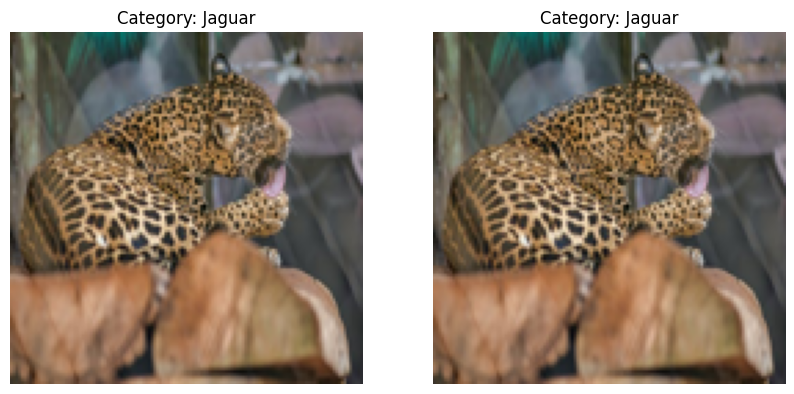

Pair  4 :
Duplicate 1 Path: /content/drive/MyDrive/BigCats/Leopard/pexels-photo-1109898.jpeg
Duplicate 2 Path: /content/drive/MyDrive/BigCats/Cheetah/pexels-photo-1109898.jpeg


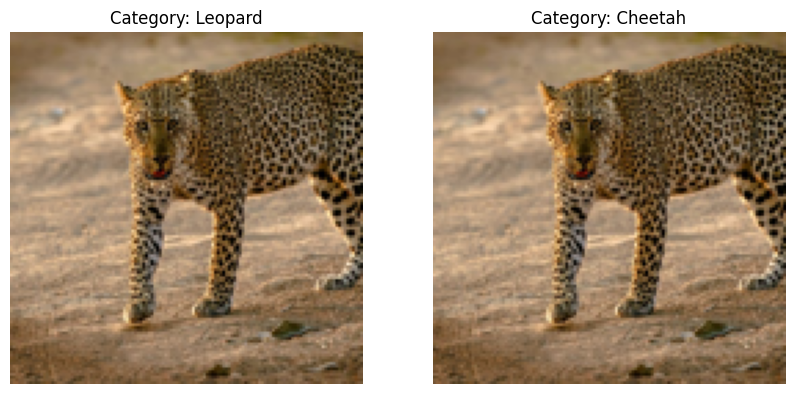

Pair  5 :
Duplicate 1 Path: /content/drive/MyDrive/BigCats/Leopard/leopard-wildcat-big-cat-botswana-46790.jpeg
Duplicate 2 Path: /content/drive/MyDrive/BigCats/Cheetah/leopard-wildcat-big-cat-botswana-46790.jpeg


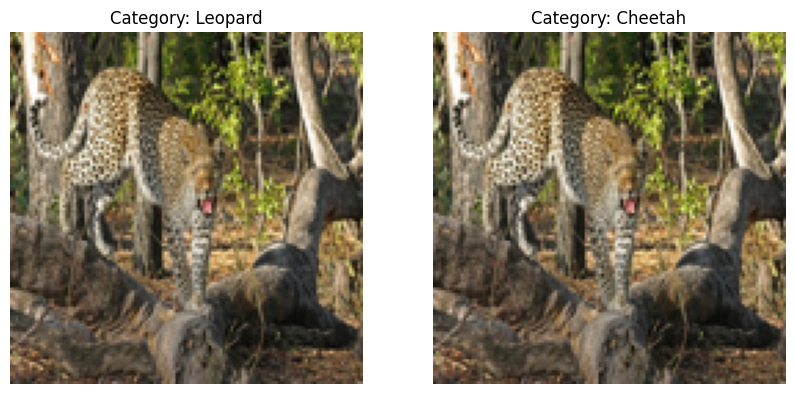

Pair  6 :
Duplicate 1 Path: /content/drive/MyDrive/BigCats/Leopard/pexels-photo-88234.jpeg
Duplicate 2 Path: /content/drive/MyDrive/BigCats/Cheetah/pexels-photo-88234.jpeg


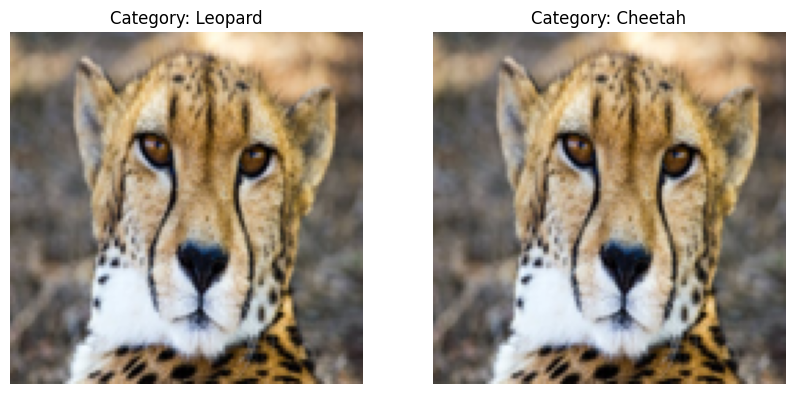

Pair  7 :
Duplicate 1 Path: /content/drive/MyDrive/BigCats/Leopard/pexels-photo-7018141.jpeg
Duplicate 2 Path: /content/drive/MyDrive/BigCats/Cheetah/pexels-photo-7018141.jpeg


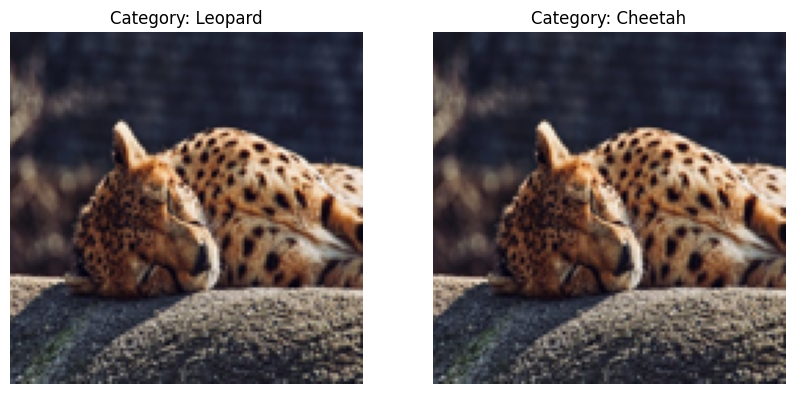

Pair  8 :
Duplicate 1 Path: /content/drive/MyDrive/BigCats/Leopard/photo-1541893321-dcc3e4dcb6dc.jpg
Duplicate 2 Path: /content/drive/MyDrive/BigCats/Jaguar/photo-1541893321-dcc3e4dcb6dc.jpg


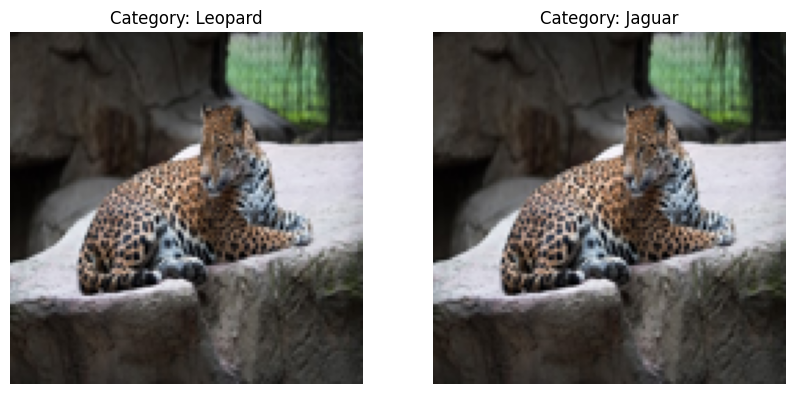

Pair  9 :
Duplicate 1 Path: /content/drive/MyDrive/BigCats/Tiger/panthera-tigris-altaica-tiger-siberian-amurtiger-162173.jpeg
Duplicate 2 Path: /content/drive/MyDrive/BigCats/Tiger/panthera-tigris-altaica-tiger-siberian-amurtiger-162203.jpeg


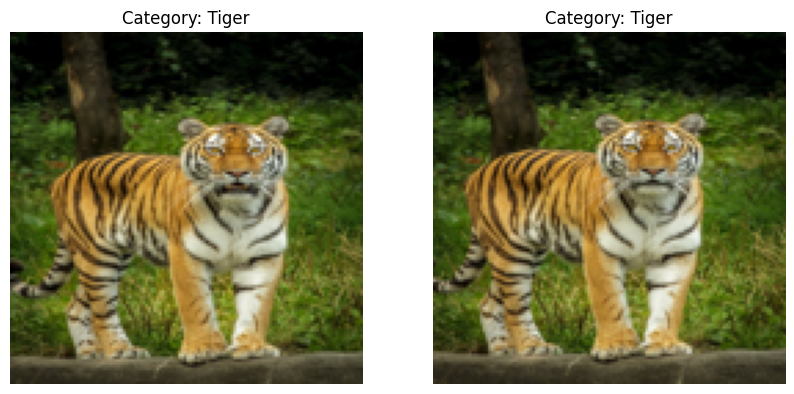

Pair  10 :
Duplicate 1 Path: /content/drive/MyDrive/BigCats/Tiger/pexels-photo-145899.jpeg
Duplicate 2 Path: /content/drive/MyDrive/BigCats/Tiger/pexels-photo-145899 (1).jpeg


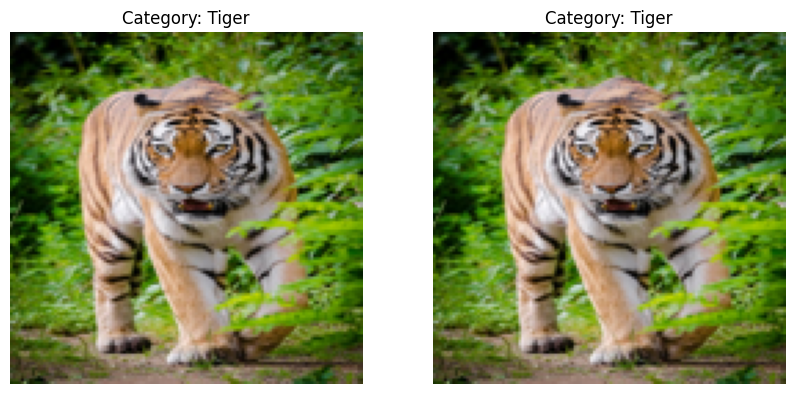

In [7]:
# Find duplicates
duplicates = find_duplicate_images(dataset_path, categories)
# Plot duplicates
plot_duplicate_images(duplicates, image_paths, labels, categories)
# Pair 9 is not duplicated; remove it from duplicates list
duplicates.pop(8)
# Create a set to keep track of indices to remove
indices_to_remove = set()
# Add duplicate indices to set
for dup in duplicates:
    dup1_path, dup2_path = dup
    # Get the indices of each duplicate in the image_paths list
    dup1_index = image_paths.index(dup1_path)
    dup2_index = image_paths.index(dup2_path)
    if labels[dup1_index] == labels[dup2_index]:
        # If both are in the same category, mark the second one for removal
        indices_to_remove.add(dup2_index)
    else:
        # If they are in different categories, mark both for removal
        indices_to_remove.add(dup1_index)
        indices_to_remove.add(dup2_index)

# Create new lists without duplicates
images_cleaned = np.array([img for i, img in enumerate(images) if i not in indices_to_remove])
labels_cleaned = np.array([label for i, label in enumerate(labels) if i not in indices_to_remove])
image_paths_cleaned = [path for i, path in enumerate(image_paths) if i not in indices_to_remove]

 Dataset and Image Analysis

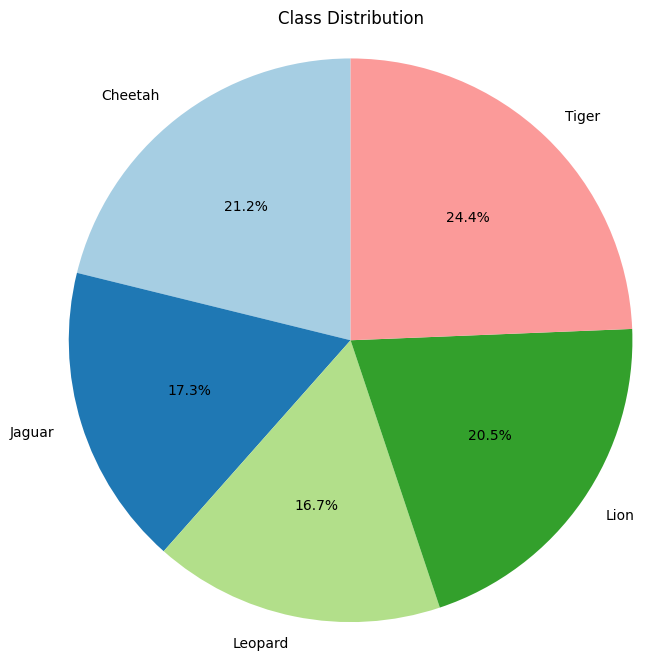

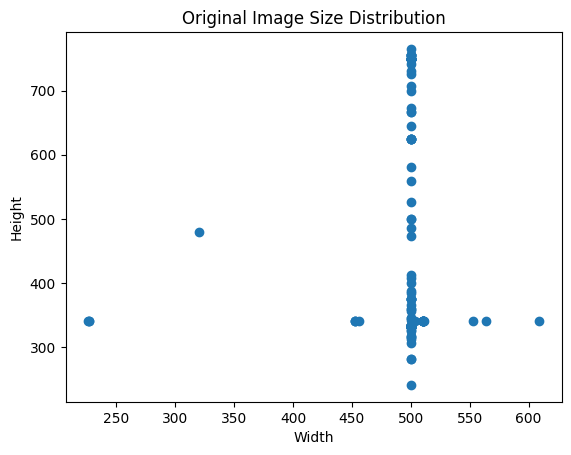

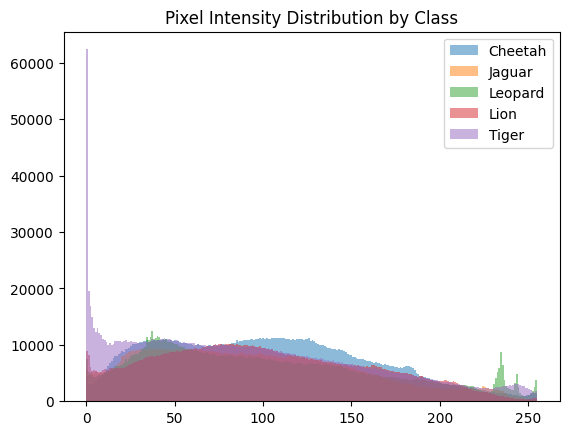

In [8]:
## Create class distribution pie-chart
# Count occurrences of each class
unique, counts = np.unique(labels_cleaned, return_counts=True)
# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=[categories[i] for i in unique], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
# Equal aspect ratio ensures the pie chart is drawn as a circle.
plt.axis('equal')
plt.title("Class Distribution")
plt.show()

# Check original sizes of images
image_sizes = [Image.open(image_paths_cleaned[i]).size for i in range(len(image_paths_cleaned))]
width, height = zip(*image_sizes)
plt.scatter(width, height)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Original Image Size Distribution")
plt.show()

# Pixel intensities
for i, category in enumerate(categories):
    plt.hist(images[labels == i].ravel(), bins=256, alpha=0.5, label=category)
plt.legend(loc='upper right')
plt.title("Pixel Intensity Distribution by Class")
plt.show()

Split

In [9]:
#%% Split to train and test set - with HOG features

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images_cleaned, labels_cleaned, test_size=0.2, random_state=20)

In [10]:
#%% Load Stratified K-Fold method

# Stratified K-Fold
n_splits = 5  # Using 5-fold cross-validation
cross_val = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=20)
# Apply HoG to identify new reduced feature space (OPTIONAL)
hog_feat, hog_img = apply_hog(images_cleaned)
print("Number of HOG features: ",len(hog_feat[1]))

Number of HOG features:  1764


Tuning Phase Example

In [11]:
#%% Train SVM and RF Classifiers - with HOG features - ANOVA only in SVM

# Feature Selection parameters
feature_grid = list(np.arange(100,1764,100)) # how many features to pick with ANOVA?
feature_grid.append(1764) # max hog features
rf_estimator_grid = [5,10,15,25,40,50,75,100,125,150,175,200,250] # how many tree estimators for rf?

# Initialize a dictionary to store metrics later
results_svm3_anova = {n: {'train': [], 'validation': []} for n in feature_grid}
results_svm4_anova = {n: {'train': [], 'validation': []} for n in feature_grid}
results_svm5_anova = {n: {'train': [], 'validation': []} for n in feature_grid}
results_svm6_anova = {n: {'train': [], 'validation': []} for n in feature_grid}
results_rf = {n: {'train': [], 'validation': []} for n in rf_estimator_grid}

## Run k-fold cross validation
for fold_index, (train_index, val_index) in enumerate(cross_val.split(X_train, y_train)):
    print("Fold " + str(fold_index + 1))
    ## Split fold sets
    x_train_fold, x_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    ## Data Augmentation - Balance the dataset  (adds complexity)
    class_augmented_images, class_augmented_labels = balanced_augmentation(x_train_fold, y_train_fold,
                                                        N_class=None)
    _, counts_ = np.unique(y_train_fold, return_counts=True)
    # Concatenate augmented images and labels with the original training data
    x_train_fold = np.concatenate((x_train_fold, class_augmented_images), axis=0)
    y_train_fold = np.concatenate((y_train_fold, np.array(class_augmented_labels)), axis=0)
    ## Apply HOG  (adds complexity)
    x_train_fold, _ = apply_hog(x_train_fold)
    x_val_fold, _ = apply_hog(x_val_fold)

    ## ANOVA with SVM
    # Feature selection using ANOVA for different numbers of features (Loop)
    for num_features in feature_grid:
        # Select the top n features based on ANOVA F-scores
        selector = SelectKBest(score_func=f_classif, k=num_features)
        x_train_selected = selector.fit_transform(x_train_fold, y_train_fold)
        x_val_selected = selector.transform(x_val_fold)
        # Train SVMs
        svm3 = SVC(kernel='poly')
        svm3.fit(x_train_selected, y_train_fold)
        svm4 = SVC(kernel='poly', degree=4)
        svm4.fit(x_train_selected, y_train_fold)
        svm5 = SVC(kernel='poly', degree=5)
        svm5.fit(x_train_selected, y_train_fold)
        svm6 = SVC(kernel='poly', degree=6)
        svm6.fit(x_train_selected, y_train_fold)
        # Predict - SVMs
        y_train_pred_svm3 = svm3.predict(x_train_selected)
        y_val_pred_svm3 = svm3.predict(x_val_selected)
        y_train_pred_svm4 = svm4.predict(x_train_selected)
        y_val_pred_svm4 = svm4.predict(x_val_selected)
        y_train_pred_svm5 = svm5.predict(x_train_selected)
        y_val_pred_svm5 = svm5.predict(x_val_selected)
        y_train_pred_svm6 = svm6.predict(x_train_selected)
        y_val_pred_svm6 = svm6.predict(x_val_selected)
        # Compute and store metrics for sets - SVM
        results_svm3_anova[num_features]['train'].append(accuracy_score(y_train_fold, y_train_pred_svm3))
        results_svm3_anova[num_features]['validation'].append(accuracy_score(y_val_fold, y_val_pred_svm3))
        results_svm4_anova[num_features]['train'].append(accuracy_score(y_train_fold, y_train_pred_svm4))
        results_svm4_anova[num_features]['validation'].append(accuracy_score(y_val_fold, y_val_pred_svm4))
        results_svm5_anova[num_features]['train'].append(accuracy_score(y_train_fold, y_train_pred_svm5))
        results_svm5_anova[num_features]['validation'].append(accuracy_score(y_val_fold, y_val_pred_svm5))
        results_svm6_anova[num_features]['train'].append(accuracy_score(y_train_fold, y_train_pred_svm6))
        results_svm6_anova[num_features]['validation'].append(accuracy_score(y_val_fold, y_val_pred_svm6))
        ## Random Forest
        for n_estimators in rf_estimator_grid:
            # Train RF
            rf = RandomForestClassifier(n_estimators=n_estimators)
            rf.fit(x_train_fold, y_train_fold)
            # Predict - RF
            y_train_pred_rf = rf.predict(x_train_fold)
            y_val_pred_rf = rf.predict(x_val_fold)
            # Compute and store metrics for sets - RF
            results_rf[n_estimators]['train'].append(accuracy_score(y_train_fold, y_train_pred_rf))
            results_rf[n_estimators]['validation'].append(accuracy_score(y_val_fold, y_val_pred_rf))


## Compute Average Accuracies over folds
# Average results over folds for ANOVA with SVM
average_results_svm3_anova = {
    (0, num_features): {
        'train': np.mean(results_svm3_anova[num_features]['train']),
        'validation': np.mean(results_svm3_anova[num_features]['validation'])
    }
    for num_features in feature_grid
}
average_results_svm4_anova = {
    (0, num_features): {
        'train': np.mean(results_svm4_anova[num_features]['train']),
        'validation': np.mean(results_svm4_anova[num_features]['validation'])
    }
    for num_features in feature_grid
}
average_results_svm5_anova = {
    (0, num_features): {
        'train': np.mean(results_svm5_anova[num_features]['train']),
        'validation': np.mean(results_svm5_anova[num_features]['validation'])
    }
    for num_features in feature_grid
}
average_results_svm6_anova = {
    (0, num_features): {
        'train': np.mean(results_svm6_anova[num_features]['train']),
        'validation': np.mean(results_svm6_anova[num_features]['validation'])
    }
    for num_features in feature_grid
}
## Compute Average Accuracies over folds
average_results_rf = {
    n_estimators: {
        'train': np.mean(results_rf[n_estimators]['train']),
        'validation': np.mean(results_rf[n_estimators]['validation'])
    }
    for n_estimators in rf_estimator_grid
}

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


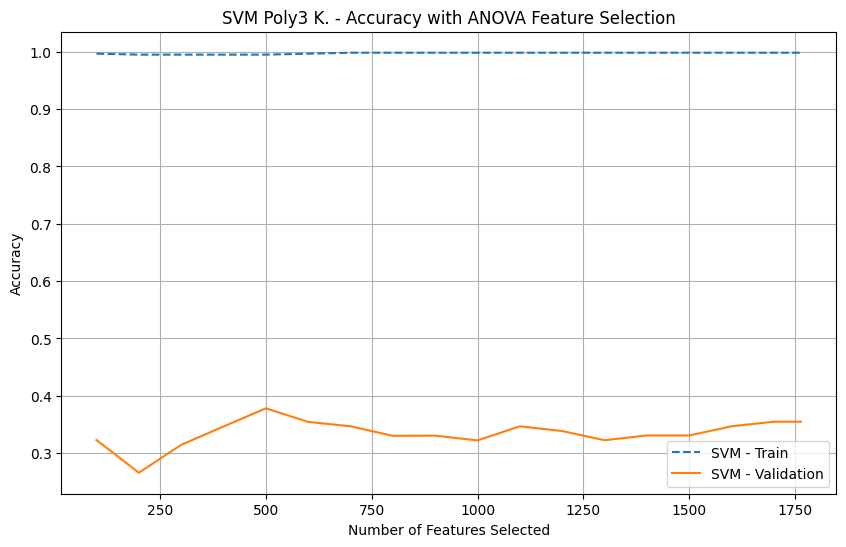

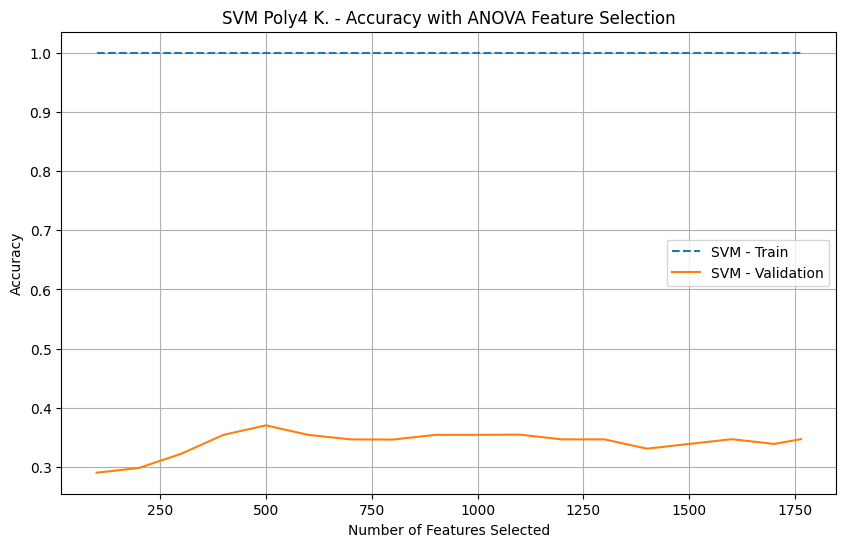

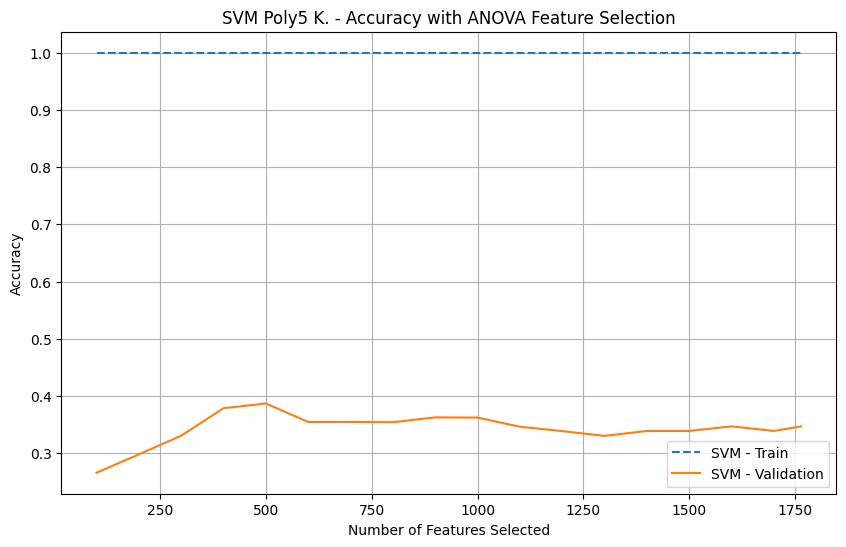

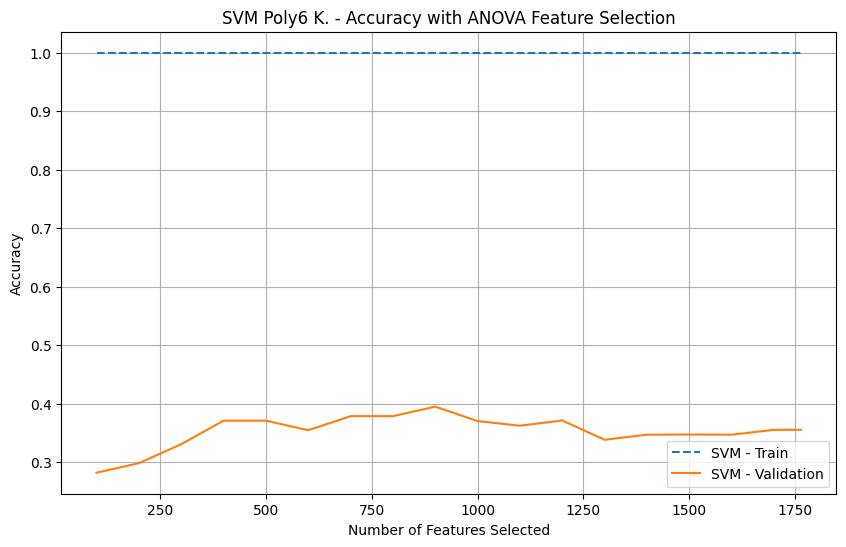

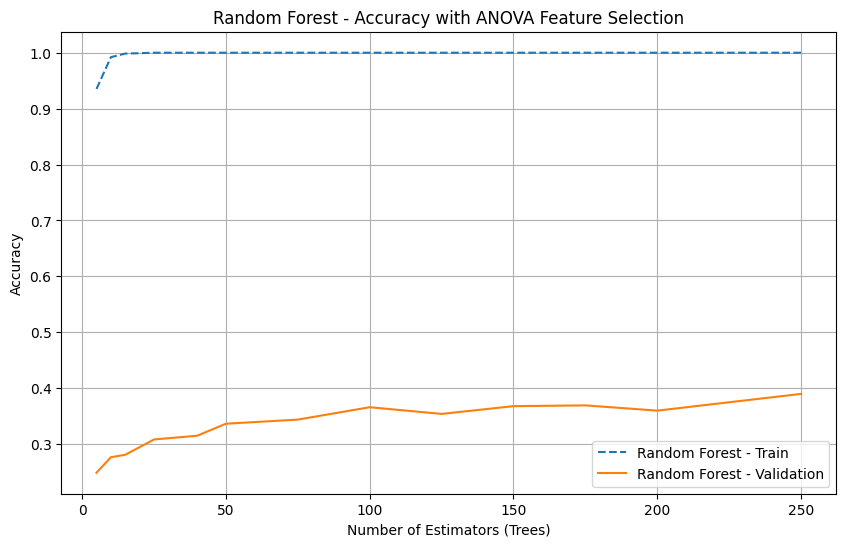

In [12]:
plot_svm_results(average_results_svm3_anova, feature_grid,
                 title = 'SVM Poly3 K. - Accuracy with ANOVA Feature Selection')
plot_svm_results(average_results_svm4_anova, feature_grid,
                 title = 'SVM Poly4 K. - Accuracy with ANOVA Feature Selection')
plot_svm_results(average_results_svm5_anova, feature_grid,
                 title = 'SVM Poly5 K. - Accuracy with ANOVA Feature Selection')
plot_svm_results(average_results_svm6_anova, feature_grid,
                 title = 'SVM Poly6 K. - Accuracy with ANOVA Feature Selection')
plot_rf_results(average_results_rf, rf_estimator_grid, title = 'Random Forest - Accuracy with ANOVA Feature Selection' )

Validate Best Model

Test Accuracy: 0.5000
Per-class Accuracies:
Class 0: 0.6000
Class 1: 0.6667
Class 2: 0.0000
Class 3: 0.3333
Class 4: 0.8750


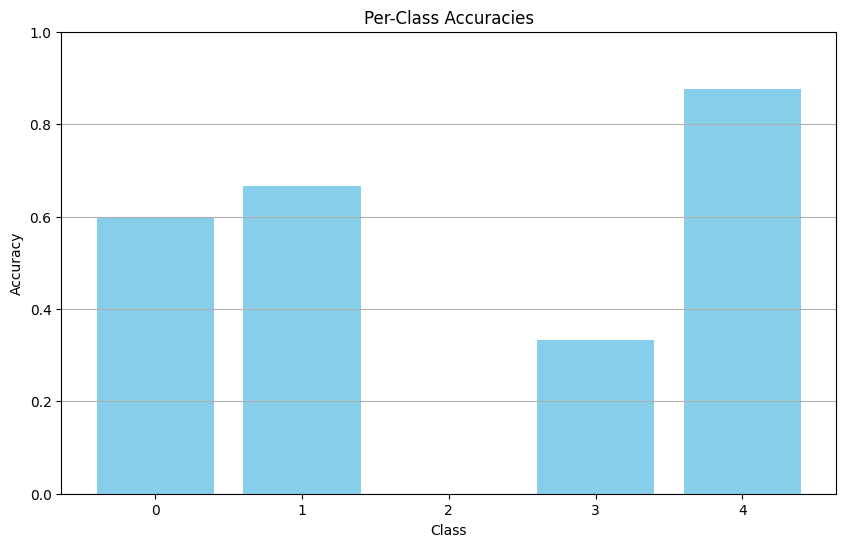

In [13]:
#%% Train and Test best model

# Best Parameter Configurations
best_num_features = 1710  # ANOVA Feature Selection
best_model_params = {'kernel': 'poly', 'degree': 10}  # SVM

# Train on entire trainset

## Data Augmentation - Balance the dataset (if needed)
class_augmented_images, class_augmented_labels = balanced_augmentation(X_train, y_train, N_class=None)

# Concatenate augmented images and labels with the original training data
X_train_augmented = np.concatenate((X_train, class_augmented_images), axis=0)
y_train_augmented = np.concatenate((y_train, np.array(class_augmented_labels)), axis=0)

## Apply HOG (Feature extraction)
X_train_hog, _ = apply_hog(X_train_augmented)
X_test_hog, _ = apply_hog(X_test)

## Feature Selection using ANOVA for the best number of features
selector = SelectKBest(score_func=f_classif, k=best_num_features)
X_train_selected = selector.fit_transform(X_train_hog, y_train_augmented)
X_test_selected = selector.transform(X_test_hog)

## Train the best SVM model
best_svm_model = SVC(**best_model_params)  # Use the best parameters you found
best_svm_model.fit(X_train_selected, y_train_augmented)

# Test on the test set
## Predict on the test set
y_test_pred = best_svm_model.predict(X_test_selected)

# Evaluate performance
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

#%% Per class accuracies

test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
per_class_accuracies = test_confusion_matrix.diagonal() / test_confusion_matrix.sum(axis=1)
# Print and plot the per-class accuracies
print("Per-class Accuracies:")
for i, accuracy in enumerate(per_class_accuracies):
    print(f"Class {i}: {accuracy:.4f}")
# Plot the per-class accuracies
plt.figure(figsize=(10, 6))
classes = np.arange(len(per_class_accuracies))  # Class labels (0, 1, 2,...)
plt.bar(classes, per_class_accuracies, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracies')
plt.xticks(classes)  # Display class numbers on the x-axis
plt.ylim([0, 1])  # Set y-axis limits to 0 to 1 (for accuracy)
plt.grid(axis='y')
plt.show()